# Deep Learning - Homework 03

### Roberto Corti

In [13]:
from google.colab import drive

folder_mount = '/content/drive' # Your Drive will be mounted on top of this path

drive.mount(folder_mount)

%cd drive/MyDrive/Università/DSSC/Secondo\ Anno/Deep-Learning/homeworks/

Mounted at /content/drive
/content/drive/MyDrive/Università/DSSC/Secondo Anno/Deep-Learning/homeworks


1. Implement L1 norm regularization as a custom loss function

In [42]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In [43]:
# Fully connected neural network with 3 hidden layers, inputsize=28*28, output
class MLP(nn.Module):
  '''
  Fully connected neural network with 3 hidden layers.
  Input size: 784
  Output size: 10
  '''
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.h1 = nn.Linear(28*28, 16)
    self.h2 = nn.Linear(16, 32)
    self.h3 = nn.Linear(32, 24)
    self.out = nn.Linear(24, 10)
    
  def forward(self, X, activ_hidden=nn.functional.relu):
    out = self.flat(X)
    out = activ_hidden(self.h1(out))
    out = activ_hidden(self.h2(out))
    out = activ_hidden(self.h3(out))
    out = self.out(out)
    return out

In [45]:
# https://stackoverflow.com/questions/66646604/http-error-503-service-unavailable-whan-trying-to-download-mnist-data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
minibatch_size_train = 256
minibatch_size_test = 512
learning_rate = 0.01

# Trasformations
transforms = Compose([
                      ToTensor(),
                      Normalize((0.1307,), (0.3081,))
                    ])

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms)



# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=minibatch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=minibatch_size_test, 
                                          shuffle=False)


--2021-03-29 20:37:46--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-29 20:37:46--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [         <=>        ]  33.20M  2.24MB/s    in 15s     

2021-03-29 20:38:02 (2.15 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


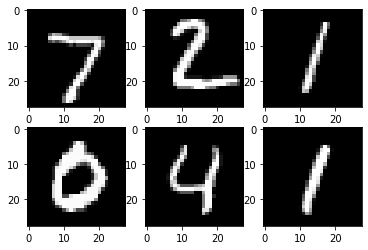

In [46]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()


In [61]:
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Number of epochs
num_epochs = 50

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Adding L1 penalty
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum() 
                         for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


Epoch [1/50], Step [100/235], Loss: 0.7692
Epoch [1/50], Step [200/235], Loss: 0.7781
Epoch [2/50], Step [100/235], Loss: 0.5808
Epoch [2/50], Step [200/235], Loss: 0.6556
Epoch [3/50], Step [100/235], Loss: 0.6217
Epoch [3/50], Step [200/235], Loss: 0.5969
Epoch [4/50], Step [100/235], Loss: 0.5777
Epoch [4/50], Step [200/235], Loss: 0.6356
Epoch [5/50], Step [100/235], Loss: 0.4823
Epoch [5/50], Step [200/235], Loss: 0.7031
Epoch [6/50], Step [100/235], Loss: 0.5534
Epoch [6/50], Step [200/235], Loss: 0.5212
Epoch [7/50], Step [100/235], Loss: 0.5329
Epoch [7/50], Step [200/235], Loss: 0.5948
Epoch [8/50], Step [100/235], Loss: 0.5618
Epoch [8/50], Step [200/235], Loss: 0.5246
Epoch [9/50], Step [100/235], Loss: 0.4921
Epoch [9/50], Step [200/235], Loss: 0.5472
Epoch [10/50], Step [100/235], Loss: 0.6476
Epoch [10/50], Step [200/235], Loss: 0.5144
Epoch [11/50], Step [100/235], Loss: 0.6045
Epoch [11/50], Step [200/235], Loss: 0.5464
Epoch [12/50], Step [100/235], Loss: 0.4805
Epoch 